In [316]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import seaborn as sns
sns.set()


from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.stattools import acf, pacf
from copy import deepcopy


from datetime import datetime

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [317]:
def plot_timeseries(dates , values):

    data = [go.Scatter(
              x=dates,
              y=values,
                mode='lines+markers'
             )]

    iplot(data)

In [318]:
def multiple_timeseries_plot(dates , values):

    data = []
    for col in values.columns:
        single_plot = go.Scatter(
                        x=dates,
                        y=values[col],
                        mode = 'lines+markers',
                        name = str(col) )
        data.append(single_plot)

    iplot(data)

In [319]:
def test_stationarity(timeseries , window = 50):
    
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

   
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean, color='red' , label='Moyenne Mobile')
    std = plt.plot(rolstd, label = 'Ecart Type Mobile')
    plt.legend(loc='best')
    plt.title('Ecart type et moyenne mobiles')
    plt.show()
    
    
    print('Résultats du test de Dickey-Fuller:')
    try:
        df_test = adfuller(timeseries.dropna(), autolag='AIC')
        df_res = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in df_test[4].items():
            df_res['Critical Value ({})'.format(key)] = value
        print(df_res) 
    except:
        print('test failed')

In [320]:
from geo_utils import filter_france_metr

df_car = pd.read_csv('data/caracteristiques.csv',dtype={'dep':'str','com':'str','code_insee':'str'})
df_car = filter_france_metr(df_car)

df_vehicules = pd.read_csv('data/vehicules.csv')
df_velos = df_vehicules[df_vehicules['catv'].isin([1,50,60,80])]
df_usagers = pd.read_csv('data/usagers.csv')
df_lieux = pd.read_csv('data/lieux.csv',low_memory=False)

In [390]:
df_accidents_velo = df_car.merge(df_velos,how='inner',on='Num_Acc')

In [391]:
df_accidents_velo.drop_duplicates(subset=['Num_Acc'], keep='last',inplace=True)

In [392]:
df_accidents_velo = filter_france_metr(df_accidents_velo)

In [393]:
df_accidents_velo_paris = df_accidents_velo[df_accidents_velo['dep']=='75']

In [394]:
df_accidents_paris = df_car[df_car['dep']=='75']

In [395]:
from date_utils import create_date_column

df_accidents_velo_paris['date'] = create_date_column(df_accidents_velo_paris)


In [396]:
df_accidents_paris['date'] = create_date_column(df_accidents_paris)

In [397]:
df_jours_feries = pd.read_csv('data/jours_feries_metropole.csv')
df_jours_feries['date'] = pd.to_datetime(df_jours_feries['date'])

In [398]:
from date_utils import add_day_month_year
add_day_month_year(df_accidents_velo_paris)
add_day_month_year(df_accidents_paris)

In [399]:
from date_utils import add_holidays
add_holidays(df_accidents_velo_paris,df_jours_feries)
add_holidays(df_accidents_paris,df_jours_feries)

In [400]:
df_accidents_velo_paris = pd.get_dummies(df_accidents_velo_paris , columns = ['day_of_week' , 'month'])
df_accidents_paris = pd.get_dummies(df_accidents_paris , columns = ['day_of_week' , 'month'])

In [401]:
group_accidents_velo_paris = df_accidents_velo_paris.groupby('date')['Num_Acc'].nunique().reset_index()
group_accidents_velo_paris

,date,Num_Acc
0,2005-01-03,2
1,2005-01-04,1
2,2005-01-05,3
3,2005-01-06,2
4,2005-01-08,1
...,...,...
5128,2021-12-27,3
5129,2021-12-28,2
5130,2021-12-29,1
5131,2021-12-30,1


In [402]:
group_accidents_paris = df_accidents_paris.groupby('date')['Num_Acc'].nunique().reset_index()
group_accidents_paris

,date,Num_Acc
0,2005-01-01,9
1,2005-01-02,10
2,2005-01-03,9
3,2005-01-04,17
4,2005-01-05,28
...,...,...
6198,2021-12-27,8
6199,2021-12-28,8
6200,2021-12-29,6
6201,2021-12-30,5


## Evolution du nombre journalier d'accidents de vélo à Paris

In [43]:

plot_timeseries(group_accidents_velo_paris.date[365*3:] , group_accidents_velo_paris.Num_Acc[365*3:] )

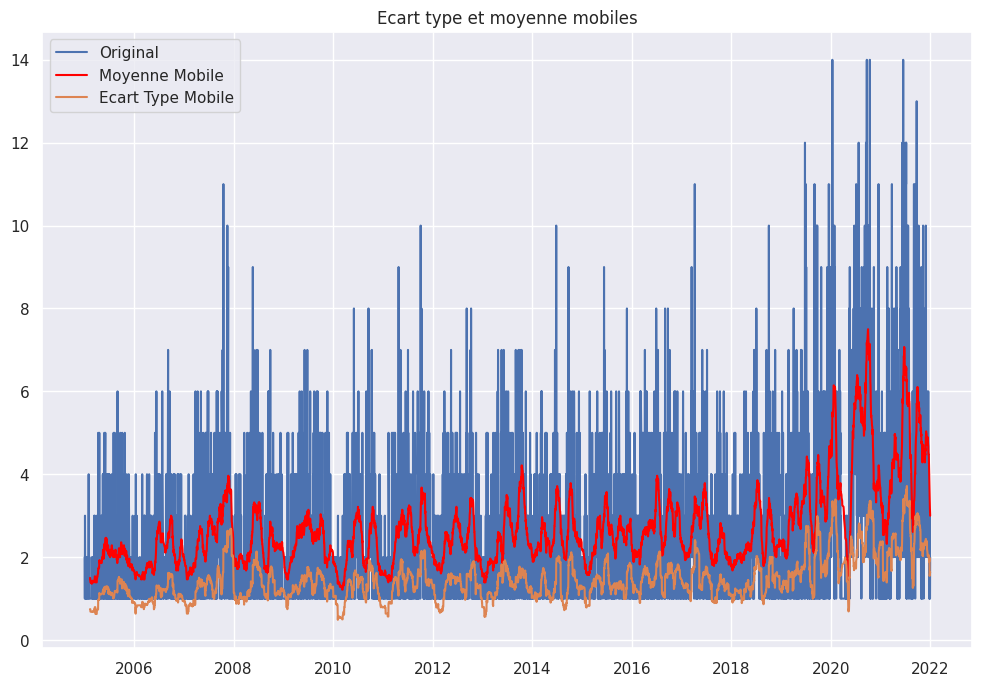

Résultats du test de Dickey-Fuller:
Test Statistic                -7.128311e+00
p-value                        3.571999e-10
#Lags Used                     2.100000e+01
Number of Observations Used    5.111000e+03
Critical Value (1%)           -3.431630e+00
Critical Value (5%)           -2.862106e+00
Critical Value (10%)          -2.567071e+00
dtype: float64


In [46]:
test_stationarity(group_accidents_velo_paris.set_index('date').Num_Acc , window = 28)

La p-value du test de Dickey-Fuller est très faible : on rejette donc l'hypothèse de non stationnarité

In [51]:
import numpy as np
def plot_acf_and_pacf(timeseries , nlags = 30):
    lag_acf = acf(timeseries, nlags=nlags)
    lag_pacf = pacf(timeseries, nlags=nlags, method='ols')
    
    print('acf')
    fig = plt.figure(figsize=(20 , 10))

    sns.barplot( x=np.arange(len(lag_acf)) , y=lag_acf , palette = 'viridis')
    
    
    plt.axhline(y=0,linestyle='--',color='red')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='red')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='red')

    plt.show();
    print('pacf')
    fig = plt.figure(figsize=(20, 10))

    sns.barplot( x=np.arange(len(lag_pacf)) , y=lag_pacf , palette = 'viridis')

    plt.axhline(y=0,linestyle='--',color='red')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='red')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='red')

    plt.show();

acf


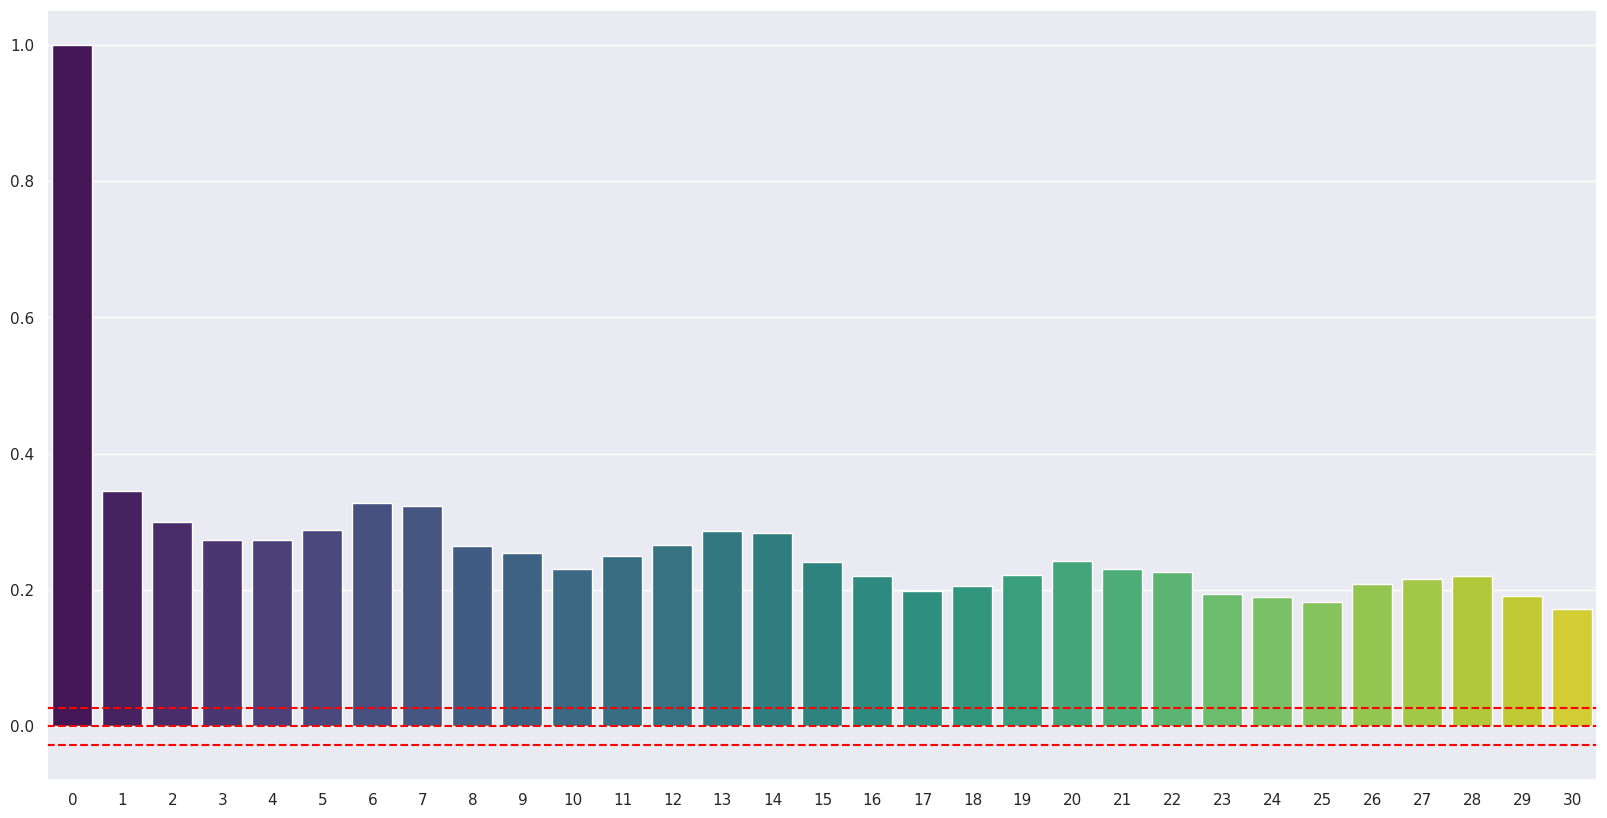

pacf


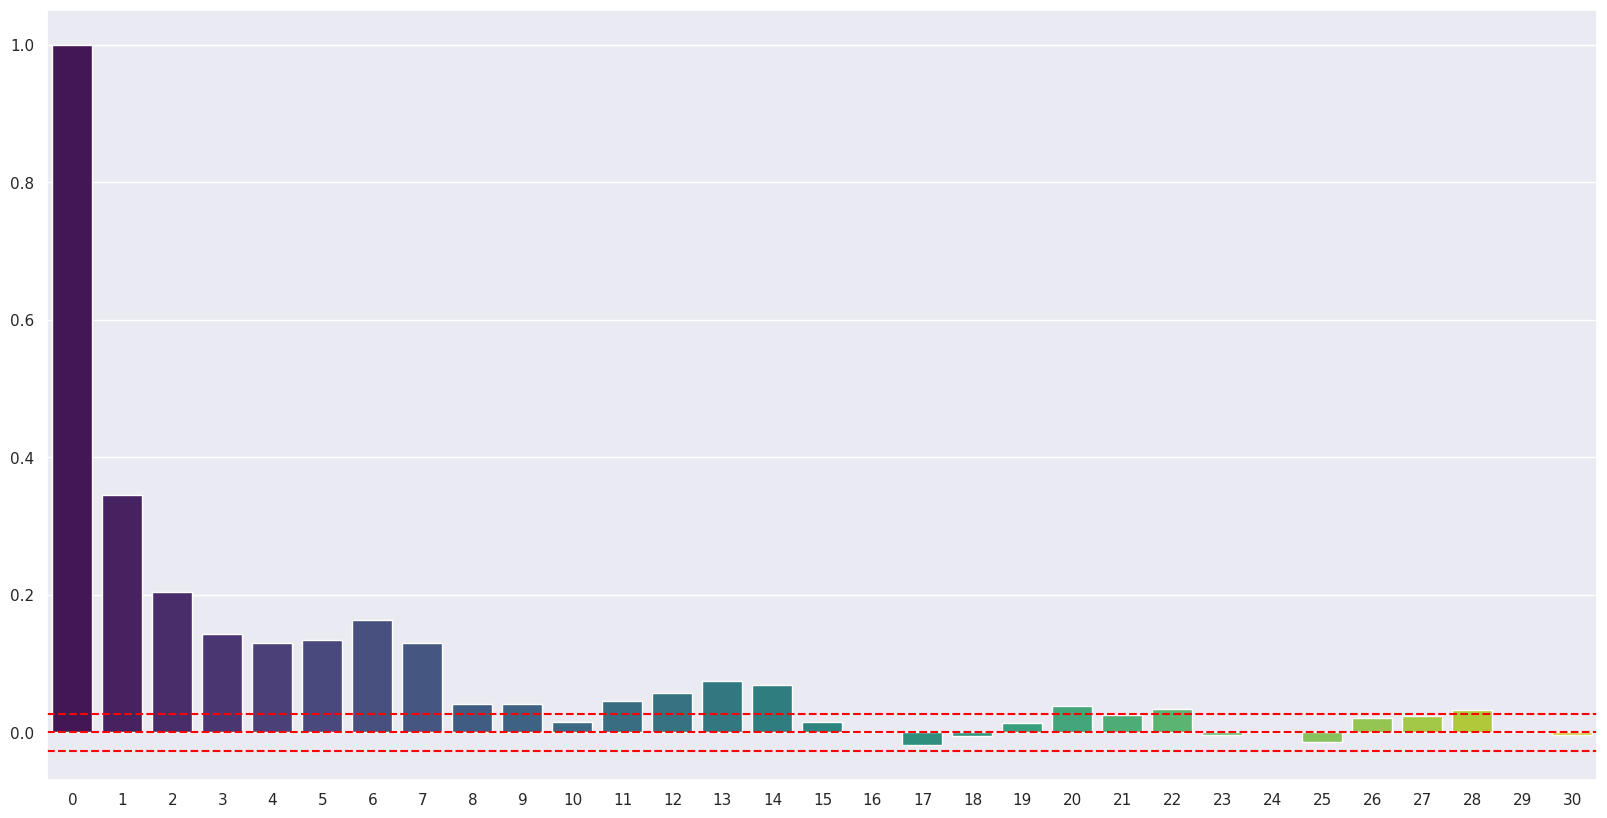

In [52]:
plot_acf_and_pacf(group_accidents_velo_paris.Num_Acc)

<Figure size 640x480 with 0 Axes>

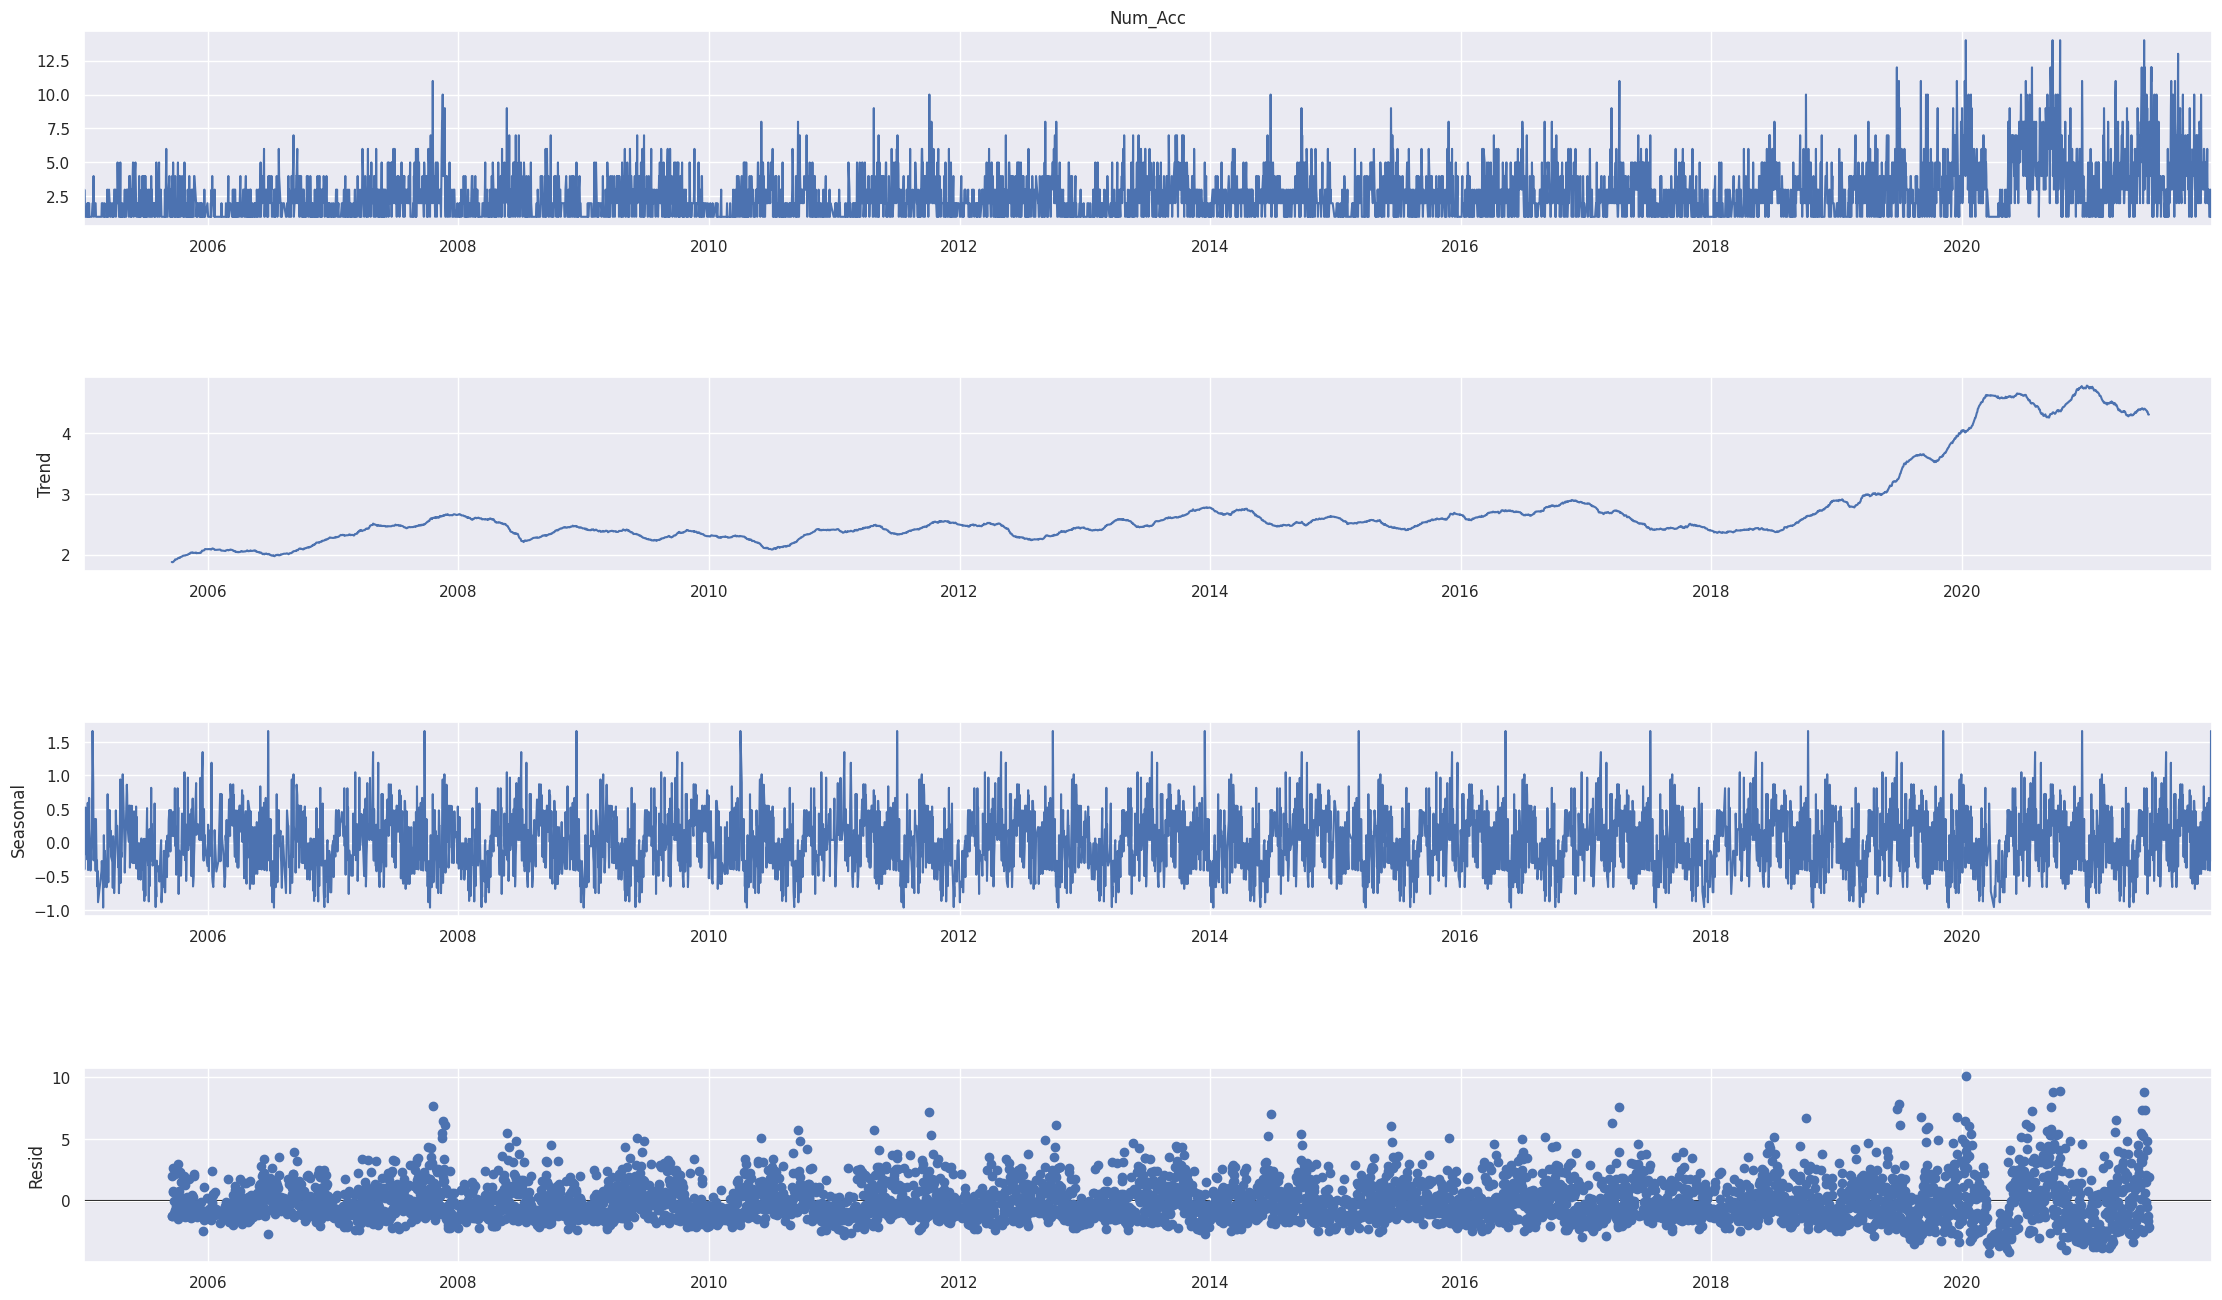

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_acc = group_accidents_velo_paris.set_index('date')
decomposition = seasonal_decompose(df_acc.Num_Acc, period=365)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(25,15)
plt.show()

Il semble y avoir une saisonalité à la semaine et à l'année des accidents de velo à Paris. On constate également une trend croissante à partir de 2018

## Evolution du nombre journalier d'accidents de la route (vélo et autres) à Paris

In [48]:
plot_timeseries(group_accidents_paris.date[365*3:] , group_accidents_paris.Num_Acc[365*3:] )

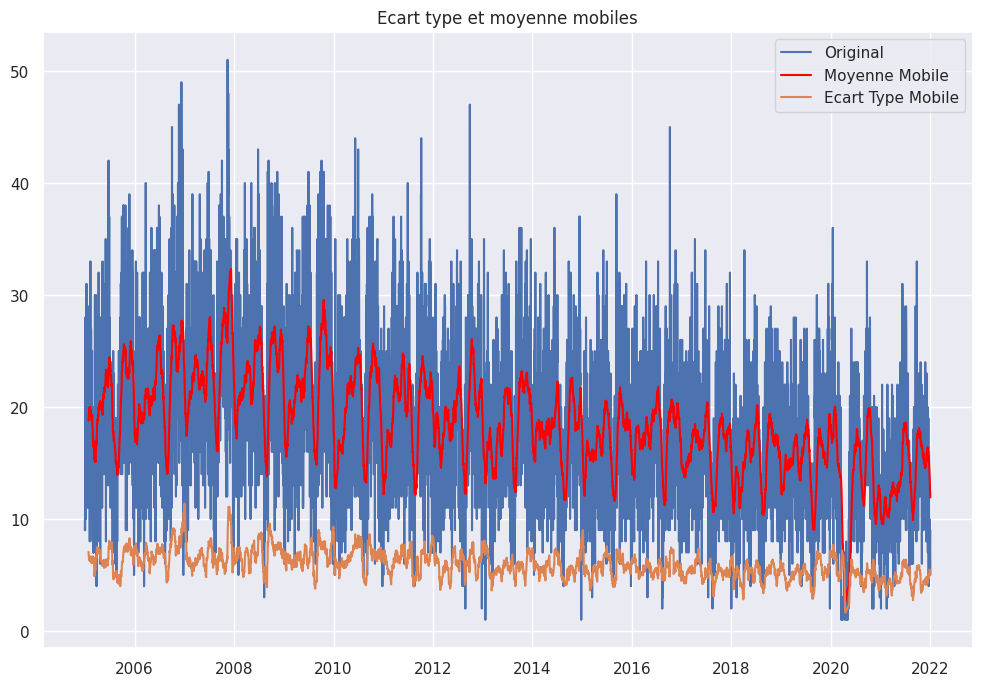

Résultats du test de Dickey-Fuller:
Test Statistic                -7.543065e+00
p-value                        3.338433e-11
#Lags Used                     3.400000e+01
Number of Observations Used    6.168000e+03
Critical Value (1%)           -3.431411e+00
Critical Value (5%)           -2.862009e+00
Critical Value (10%)          -2.567019e+00
dtype: float64


In [49]:
test_stationarity(group_accidents_paris.set_index('date').Num_Acc , window = 28)

La p-value nous indique que la série temporelle des accidents de la route à Paris est elle aussi stationnaire

acf


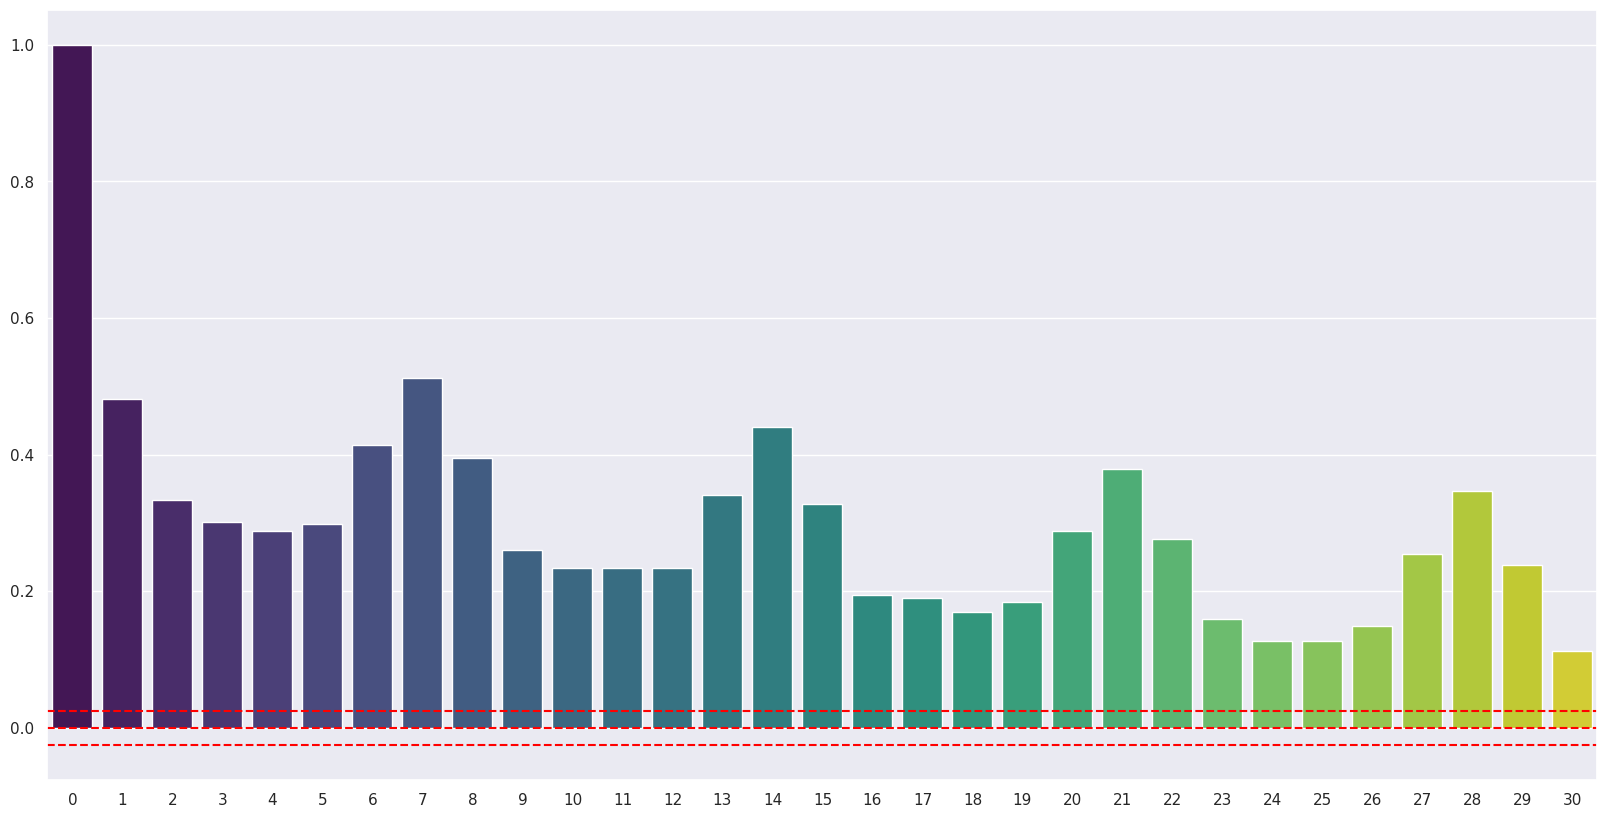

pacf


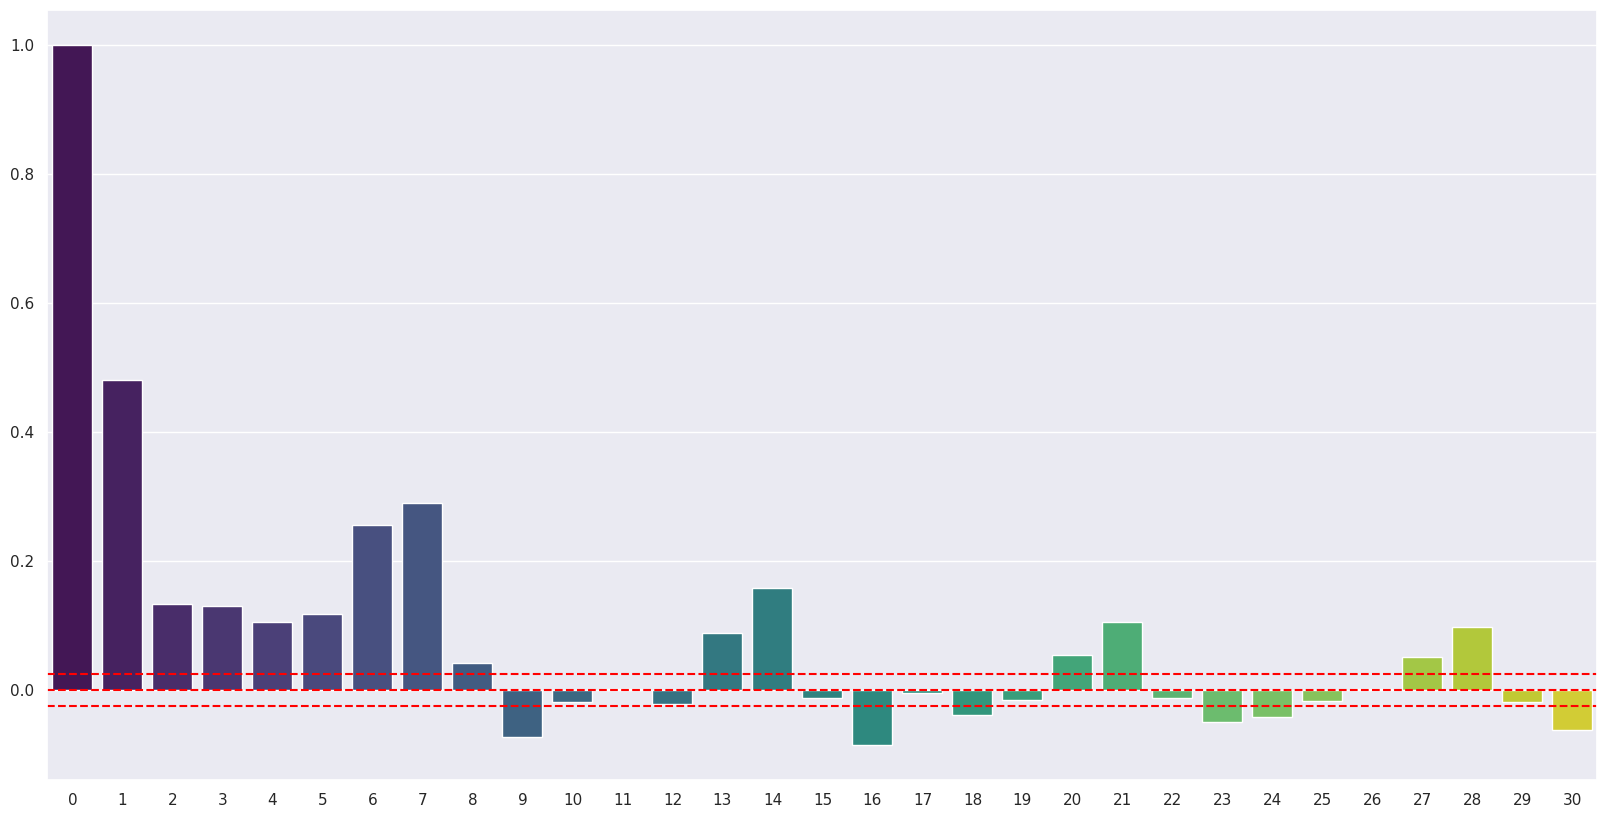

In [53]:
plot_acf_and_pacf(group_accidents_paris.Num_Acc)

Ici, la saisonalité à la semaine est encore plus clairement visible

<Figure size 640x480 with 0 Axes>

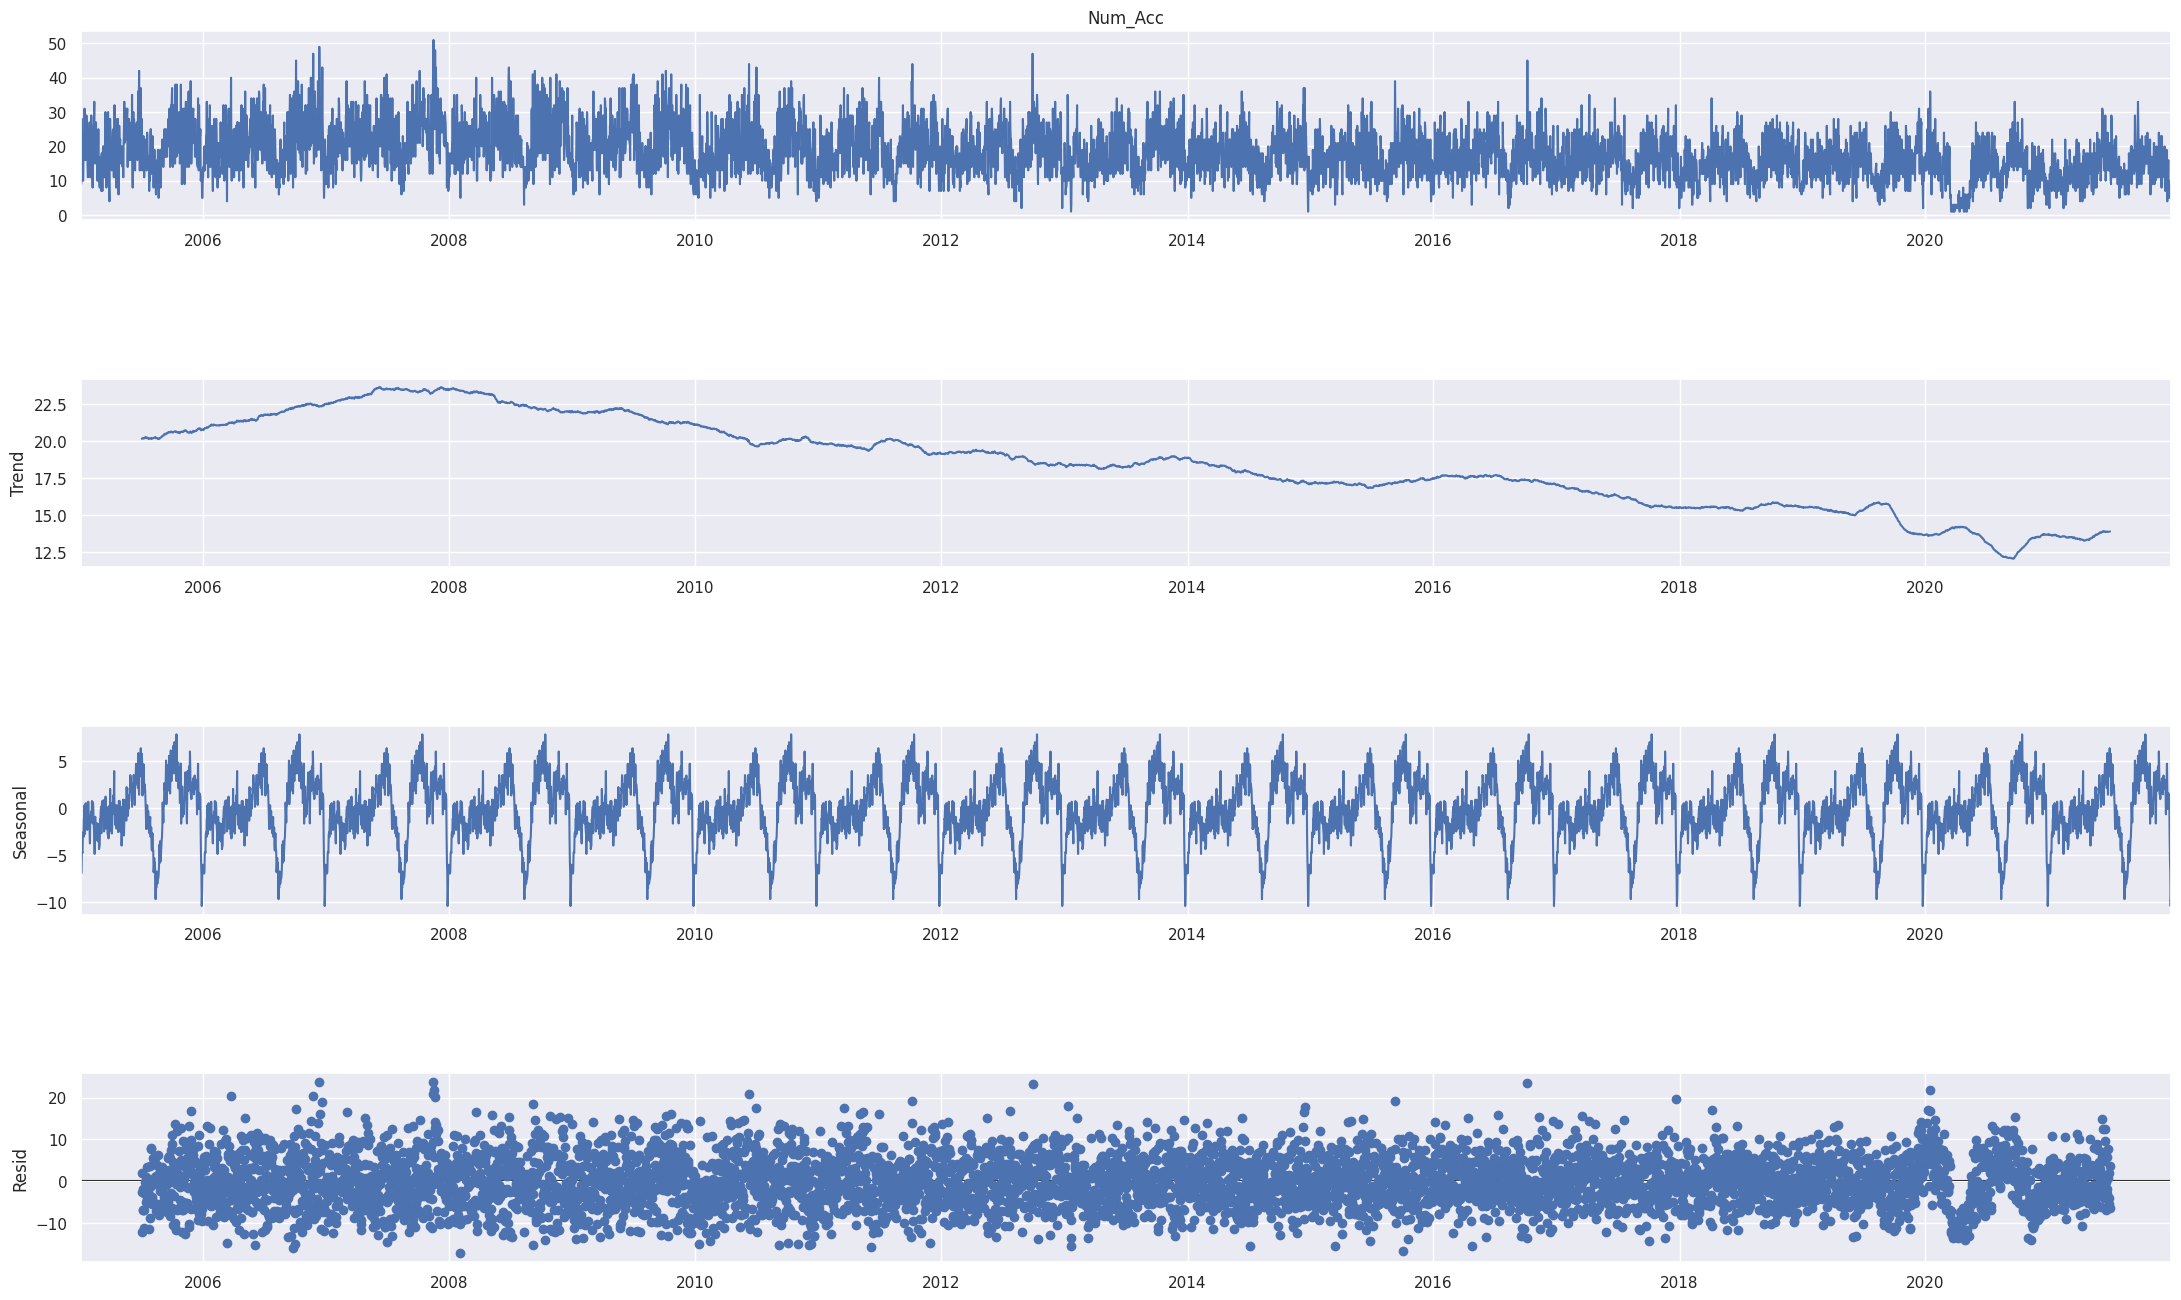

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_acc = group_accidents_paris.set_index('date')
decomposition = seasonal_decompose(df_acc.Num_Acc, period=365)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(25,15)
plt.show()

On retrouve également une saisonalité annuelle avec cette fois une tendance plutôt décroissante depuis 2008

## Predictions avec Prophet

In [345]:
from prophet import Prophet

In [346]:
def evaluate(y_true , y_pred , dates):
    
    try:
        true_val , pred = y_true.sum(axis = 1), y_pred.sum(axis=1).round()
    except:
        true_val , pred = y_true, y_pred.round()
    
    print('MAE   :' , round(np.abs(true_val - pred).mean() , 2)) 
    print('RMSE:' , round(np.sqrt(((true_val - pred)**2).mean()) , 2) )
    print('MPE :' , round(np.mean(np.isfinite(np.abs(true_val- pred)/true_val)) , 2)  )
    
    err = pd.Series(true_val - pred)
    
    # Moyenne de l'erreur et corrélation :
    print('Mean Error                       :' , round(np.mean(err) , 2 ))
    print("Correlation en la vraie valeur et l'erreur :" , round(np.corrcoef(err , true_val)[0 , 1] , 2))
    
    # plot predictions
    
    to_plot = pd.DataFrame({'target' : y_true.reshape(-1) , 'prediction' : y_pred.reshape(-1)})
    
    multiple_timeseries_plot(dates , to_plot)

In [347]:
df_jours_feries = df_jours_feries[['date','nom_jour_ferie']]

In [348]:
df_jours_feries['date'] = pd.to_datetime(df_jours_feries['date'])
#meet profet requirements
df_jours_feries.columns = ['ds','holiday']

In [349]:
df_traffic = pd.read_csv('data/trafic-velos-since-2020.csv',low_memory=False)

In [350]:
from geo_utils import filter_paris_postcodes
df_traffic = filter_paris_postcodes(df_traffic)

In [351]:
df_traffic_date = df_traffic[['sum_counts','date']].groupby(by=['date'], as_index=False).sum()
df_traffic_date

,date,sum_counts
0,2020-01-01,47609.0
1,2020-01-02,107474.0
2,2020-01-03,118533.0
3,2020-01-04,100113.0
4,2020-01-05,80912.0
...,...,...
1107,2023-01-12,171530.0
1108,2023-01-13,162623.0
1109,2023-01-14,83179.0
1110,2023-01-15,95881.0


In [355]:
#Initialisation du modèle
model = Prophet(holidays = df_jours_feries,\
                seasonality_mode='additive', yearly_seasonality=True , weekly_seasonality=True, daily_seasonality=True)


#train & test set.
train ,  test = group_accidents_paris[(group_accidents_paris.date.dt.year < 2020)&(group_accidents_paris.date.dt.year >= 2010)].reset_index(drop = True) ,\
group_accidents_paris[group_accidents_paris.date.dt.year == 2021].reset_index(drop = True)

# Renommage des colonnes avant de fitter avec Prophet
ncols = train.columns.values
ncols[0] , ncols[1] = 'ds' , 'y'

train.columns , test.columns = ncols , ncols
train['y'] = np.log(train['y']+1)

# Entrainement du modèle
model.fit(train)

# Prediction
y_pred = (np.exp(model.predict(test)['yhat'])-1).round()

# Evaluation
evaluate(test.y.values , y_pred.values , group_accidents_paris[group_accidents_paris.date.dt.year == 2021].date[-180:])


DEBUG:cmdstanpy:input tempfile: /tmp/tmp2hrav_v5/8d89flh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2hrav_v5/3umuz3x8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/romainfournier/.local/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15871', 'data', 'file=/tmp/tmp2hrav_v5/8d89flh8.json', 'init=/tmp/tmp2hrav_v5/3umuz3x8.json', 'output', 'file=/tmp/tmp2hrav_v5/prophet_modelr9ffxmn2/prophet_model-20230119113856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:38:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE   : 3.35
RMSE: 4.29
MPE : 1.0
Mean Error                       : 0.53
Correlation en la vraie valeur et l'erreur : 0.79


In [372]:
model = Prophet(holidays = df_jours_feries ,seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
group_accidents_paris.columns=['ds','y']
model.fit(group_accidents_paris)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)
plot_timeseries(forecast['ds'][-180:],forecast['yhat'][-180:])
group_accidents_paris.columns=['date','sum_counts']

00:42:16 - cmdstanpy - INFO - Chain [1] start processing
00:42:17 - cmdstanpy - INFO - Chain [1] done processing


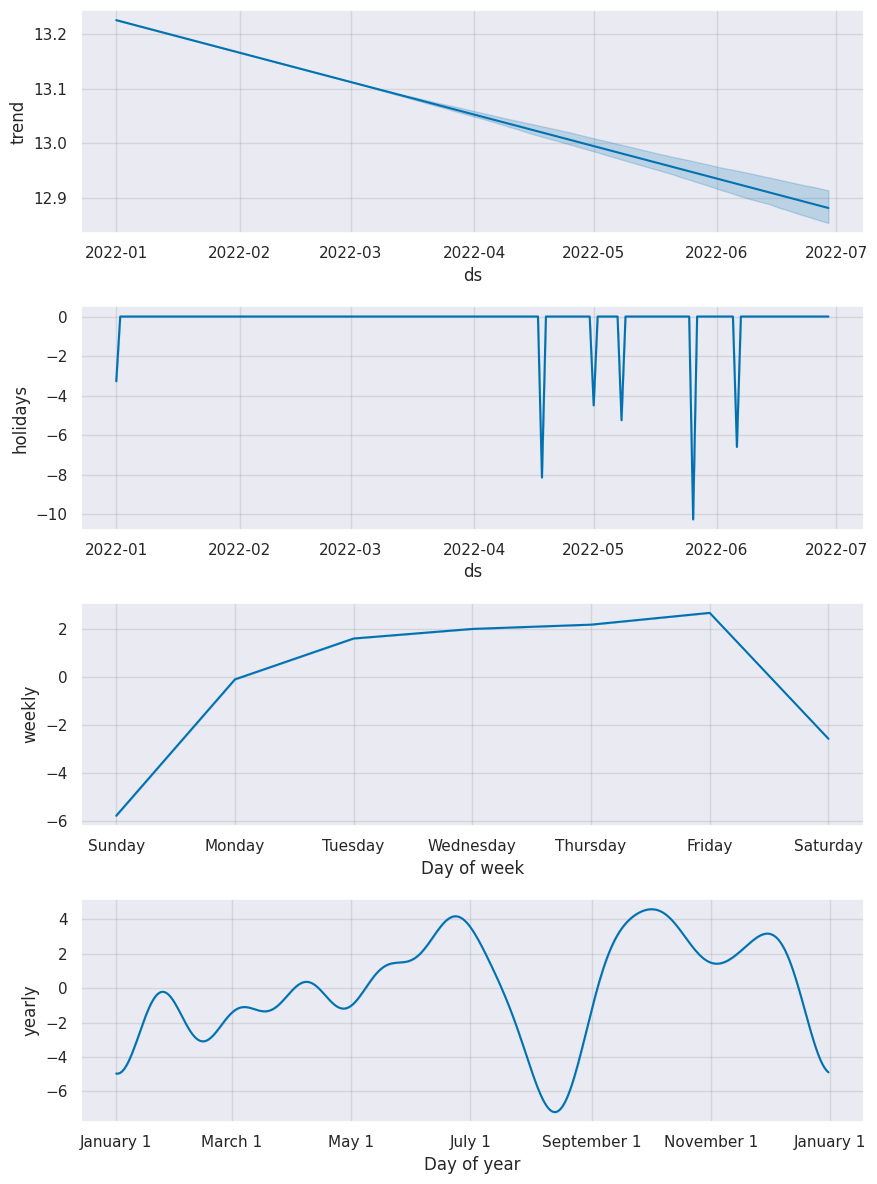

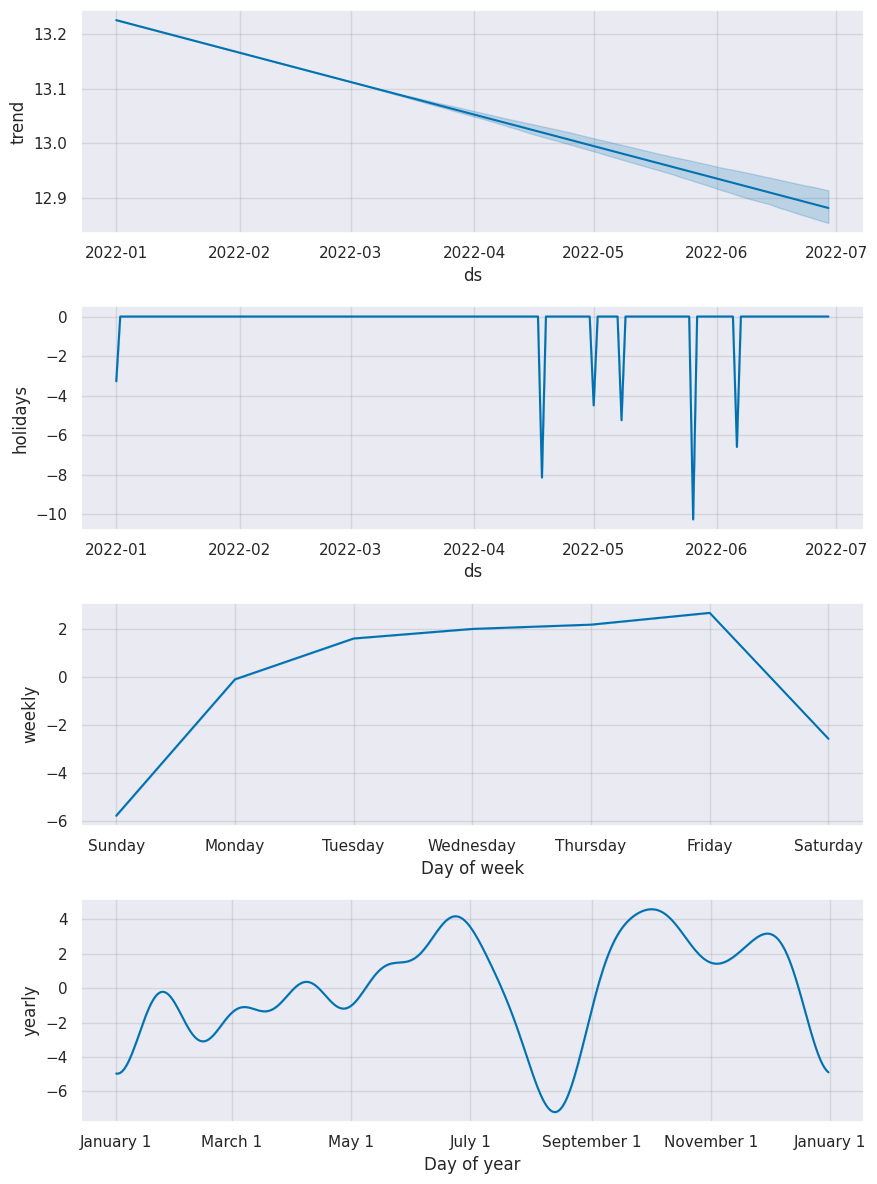

In [368]:
model.plot_components(forecast[-180:])

In [374]:
#Initialisation du modèle
model = Prophet(holidays = df_jours_feries ,seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

#train & test set.
train ,  test = group_accidents_velo_paris[(group_accidents_velo_paris.date.dt.year < 2020)&((group_accidents_velo_paris.date.dt.year >= 2018))].reset_index(drop = True) ,\
group_accidents_velo_paris[group_accidents_velo_paris.date.dt.year == 2021].reset_index(drop = True)

# Renommage des colonnes avant de fitter avec Prophet
ncols = train.columns.values
ncols[0] , ncols[1] = 'ds' , 'y'

train.columns , test.columns = ncols , ncols
train['y'] = np.log(train['y']+1)

# Entrainement du modèle
model.fit(train)

# Prediction
y_pred_velo = (np.exp(model.predict(test)['yhat'])-1).round()

# Evaluation
evaluate(test.y.values , y_pred_velo.values , group_accidents_velo_paris[group_accidents_velo_paris.date.dt.year == 2021].date[-365:])

00:43:46 - cmdstanpy - INFO - Chain [1] start processing
00:43:46 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 2.06
RMSE: 2.53
MPE : 0.87
Mean Error                       : -0.83
Correlation en la vraie valeur et l'erreur : 0.86


In [375]:
model = Prophet(holidays = df_jours_feries ,seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
group_accidents_velo_paris.columns=['ds','y']
model.fit(group_accidents_velo_paris)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)
plot_timeseries(forecast['ds'][-180:],forecast['yhat'][-180:])
group_accidents_velo_paris.columns=['date','sum_counts']

00:44:28 - cmdstanpy - INFO - Chain [1] start processing
00:44:29 - cmdstanpy - INFO - Chain [1] done processing


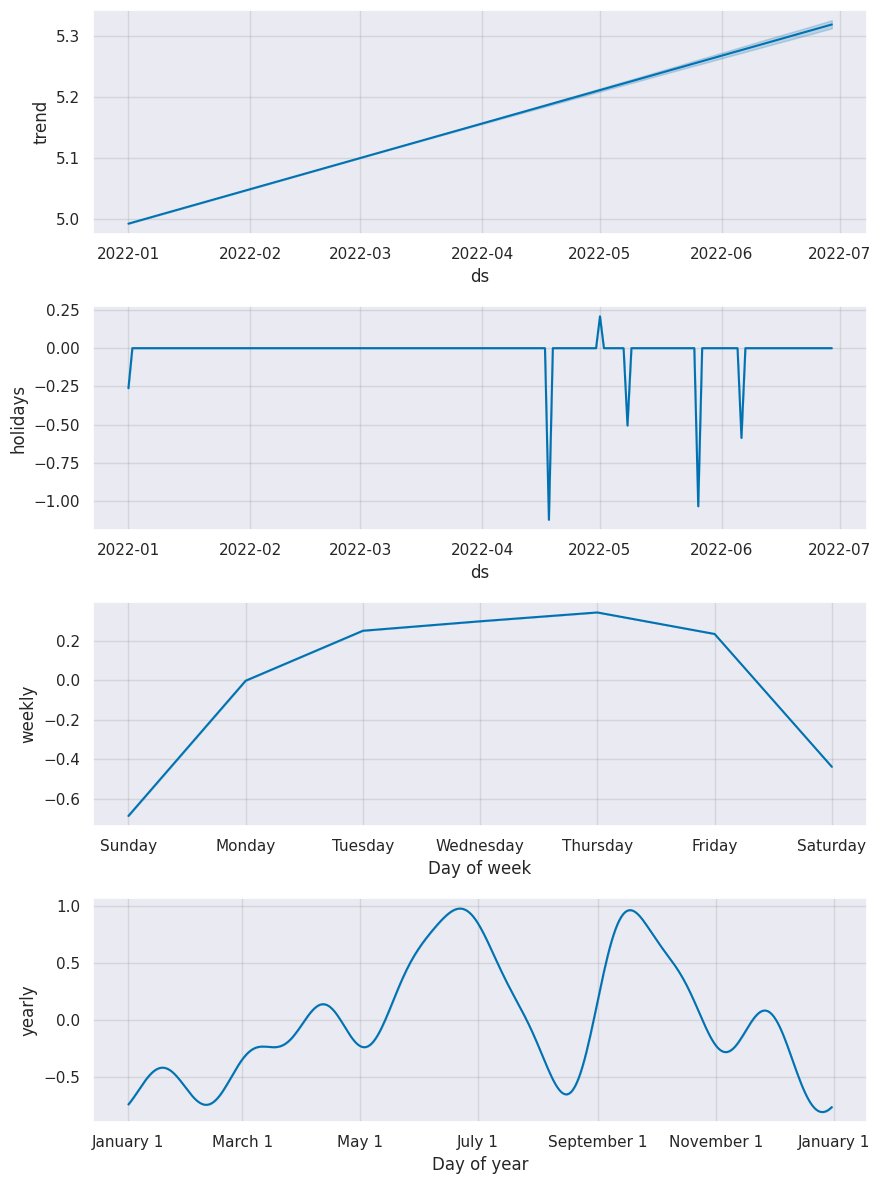

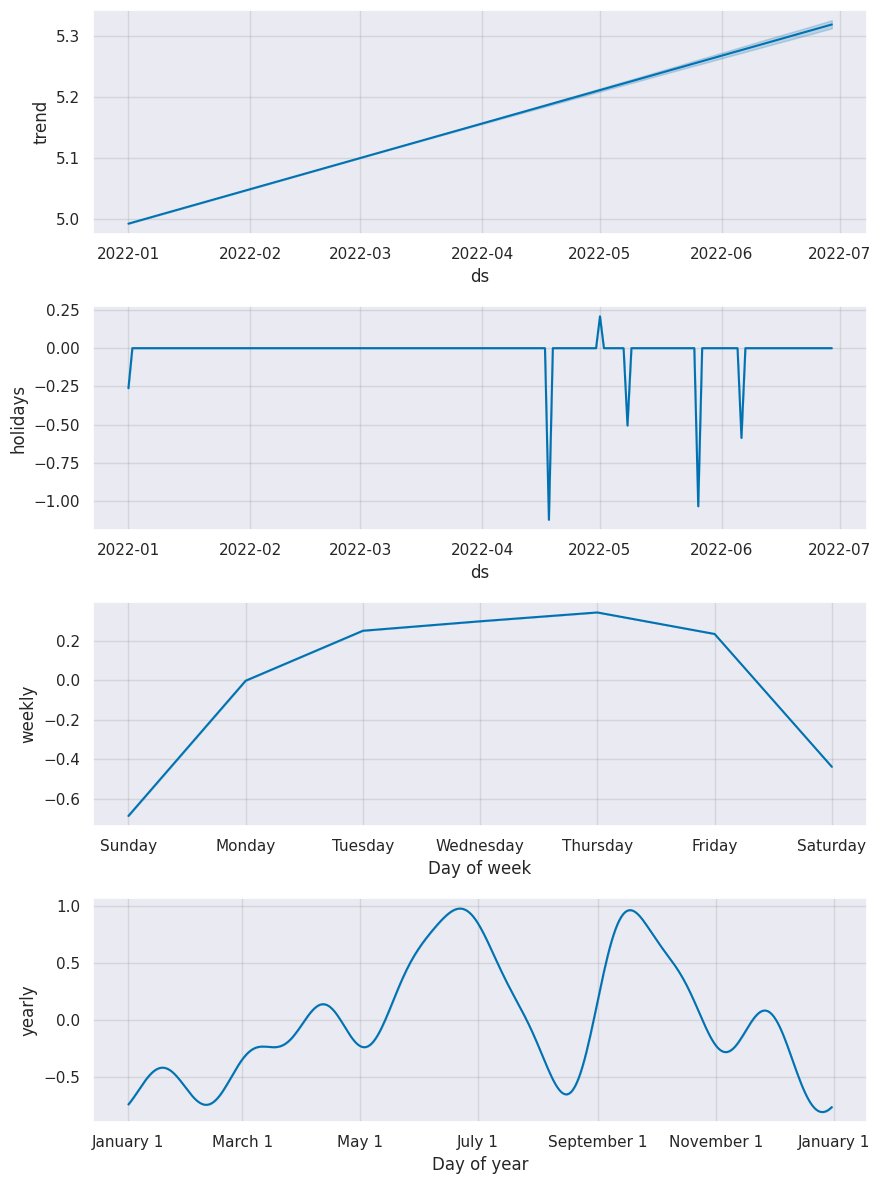

In [377]:
model.plot_components(forecast[-180:])

In [381]:
df_stacked =group_accidents_paris.reset_index(level=0).merge(group_accidents_velo_paris.reset_index(level=0),how='left',on='date')

In [384]:
df_stacked['y_y'] = df_stacked['sum_counts_y'].fillna(0)

In [385]:
df_stacked['accidentality'] = df_stacked['y_y']/df_stacked['sum_counts_x']

In [387]:
to_plot = pd.DataFrame({'target' : df_stacked[df_stacked['date'].dt.year==2021]['accidentality'].to_numpy().reshape(-1) ,
                        'prediction' : (y_pred_velo/y_pred).to_numpy().reshape(-1)})
multiple_timeseries_plot(df_stacked[df_stacked['date'].dt.year==2021]['date'] , to_plot)

In [393]:
df_traffic_date['date'] = pd.to_datetime(df_traffic_date['date'])
df_traffic_date['sum_counts'] = df_traffic_date['sum_counts']/1000

In [394]:


#Initialisation du modèle
model = Prophet(holidays = df_jours_feries ,seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

#train & test set.
train ,  test = df_traffic_date[df_traffic_date.date < pd.to_datetime('2022-07-11')].reset_index(drop = True) ,\
df_traffic_date[df_traffic_date.date >= pd.to_datetime('2022-07-11')].reset_index(drop = True)

# Renommage des colonnes avant de fitter avec Prophet
ncols = train.columns.values
ncols[0] , ncols[1] = 'ds' , 'y'

train.columns , test.columns = ncols , ncols

# Entrainement du modèle
model.fit(train)

# Prediction
y_pred_velo = model.predict(test)['yhat'].round()

# Evaluation
evaluate(test.y.values , y_pred_velo.values , df_traffic_date[df_traffic_date.date >= pd.to_datetime('2022-07-11')].date)

00:48:52 - cmdstanpy - INFO - Chain [1] start processing
00:48:52 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 30.67
RMSE: 37.91
MPE : 0.26
Mean Error                       : -24.75
Correlation en la vraie valeur et l'erreur : 0.56


In [395]:
model = Prophet(holidays = df_jours_feries ,seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
df_traffic_date.columns=['ds','y']
model.fit(df_traffic_date)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)
plot_timeseries(forecast['ds'][-180:],forecast['yhat'][-180:])

00:48:58 - cmdstanpy - INFO - Chain [1] start processing
00:48:58 - cmdstanpy - INFO - Chain [1] done processing


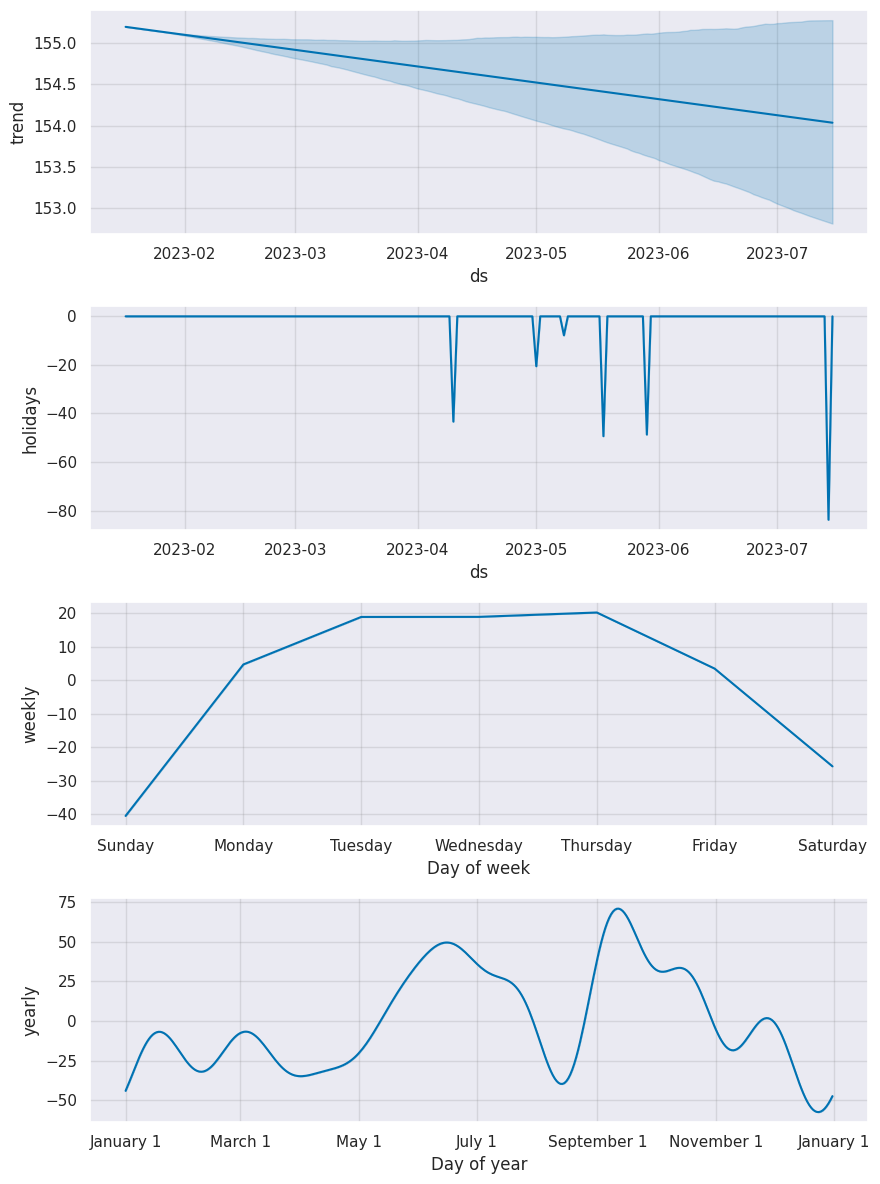

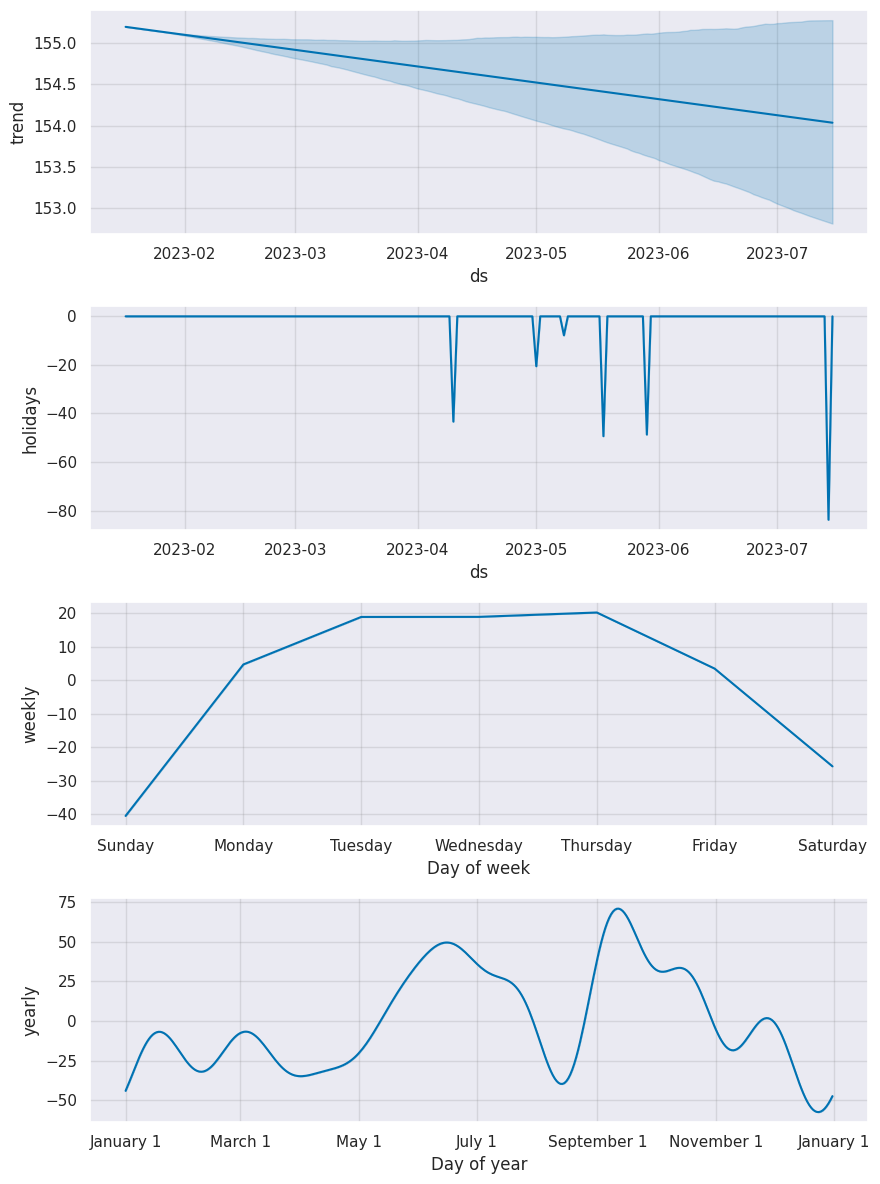

In [396]:
model.plot_components(forecast[-180:])

## Predictions par arrondissement avec un Bi-LSTM

## Prediction du nombre d'accidents de vélos par arrondissement sur l'année à venir


In [403]:
group_ardt_date = df_accidents_velo_paris.groupby(['date' , 'code_insee'] , as_index = False).count()
piv_t = group_ardt_date.pivot_table(index = ['date'] , columns = 'code_insee' , values = 'Num_Acc').reset_index()
group_ardt_date = piv_t.fillna(0)

In [404]:
group_ardt_date.shape

(5133, 21)

In [405]:
add_holidays(group_ardt_date,df_jours_feries)

In [406]:
add_day_month_year(group_ardt_date)
group_ardt_date = pd.get_dummies(group_ardt_date , columns = ['day_of_week' , 'month'])


In [407]:
from timeseries_utils import reshape_timeseries, lstm_model
X , Y , maxs = reshape_timeseries(group_ardt_date.iloc[: , 1:] , list(range(20)), win_size = 28 , take_curr = True , scale = True)

ntest_day = 365

nmodel = lstm_model(X , Y , lr = 0.005, lstm_layers = [64 , 64] , lstm_dropout = [.2 , .2] ,
               dense_layers = [64] , dense_dropout = [.2] , batch_size = 64 , epochs = 20)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   1.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]] [[0.         0.         0.         ... 0.         0.33333333 0.        ]
 [0.25       0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.33333333 0.        ]
 [0.         0.         0.         ... 0.         0.         0.33333333]
 [0.         0.         0.         ... 0.         0.33333333 0.        ]]



KeyboardInterrupt



In [408]:
import numpy as np
y_predict = (nmodel.predict(X[- ntest_day:]) * maxs).sum(axis=1)
y_true = (Y[- ntest_day:] * maxs).sum(axis=1)


evaluate(y_true , y_predict , group_ardt_date.date[-365:])

12/12 [==============================] - 0s 28ms/step
MAE   : 1.56
RMSE: 2.12
MPE : 0.97
Mean Error                       : 1.28
Correlation en la vraie valeur et l'erreur : 0.79


In [409]:
from copy import deepcopy
import numpy as np
def long_term_prediction(model , X , nb_targets):   
    preds = []
    new_line = X[0].reshape(1 , *X.shape[1:])
    pred = model.predict(new_line)
    preds.append(pred)
    
    
    for line in X[1:]:
        old_line = deepcopy(line)
        old_line[-2 , :nb_targets] = pred
        pred= model.predict(old_line.reshape(1 , *X.shape[1:]))
        preds.append(pred)
        
    return np.array(preds).reshape(-1 , nb_targets )

In [410]:
def get_prediction_dates(last_date,num_prediction):
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

In [431]:
# Evaluation long terme:
X , Y , maxs = reshape_timeseries(group_ardt_date.iloc[: , 1:] , list(range(20)), win_size = 28 , take_curr = True , scale = True)
long_term_preds = long_term_prediction(nmodel , X[- 365:] , 20)
y_predict =( long_term_preds* maxs)
y_true = (Y[- 365:] * maxs)
    


[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   1.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]
 [0.   0.   0.   ... 0.   0.   1.  ]] [[0.         0.         0.         ... 0.         0.33333333 0.        ]
 [0.25       0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.33333333 0.        ]
 [0.         0.         0.         ... 0.         0.         0.33333333]
 [0.         0.         0.         ... 0.         0.33333333 0.        ]]
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 35ms/step


In [432]:
evaluate(y_true.sum(axis=1), y_predict.sum(axis=1) , group_ardt_date.date[-365:])

MAE   : 1.56
RMSE: 2.13
MPE : 0.97
Mean Error                       : 1.28
Correlation en la vraie valeur et l'erreur : 0.79


In [449]:
y_predict.sum(axis=0).round(), y_true.sum(axis=0).round()

(array([108.,  28.,  71.,  64.,  94.,  58.,  36.,  47.,  62.,  54.,  78.,
         43.,  15.,  25., 131.,  36.,  28.,  34.,  46.,  68.]),
 array([114.,  52.,  74., 115., 117.,  75.,  92.,  71.,  44.,  93., 102.,
        113.,  54.,  42., 102.,  84.,  46.,  26.,  84.,  91.]))

In [450]:
df_res = pd.DataFrame({'pred':y_predict.sum(axis=0).round(),'true': y_true.sum(axis=0).round()})

In [451]:
df_res.sort_values(by='pred',ascending=False)

,pred,true
14,131.0,102.0
0,108.0,114.0
4,94.0,117.0
10,78.0,102.0
2,71.0,74.0
19,68.0,91.0
3,64.0,115.0
8,62.0,44.0
5,58.0,75.0
9,54.0,93.0


## Prediction des accidents de la route à Paris sur l'année à venir

In [452]:
group_ardt_date_all = df_accidents_paris.groupby(['date' , 'code_insee'] , as_index = False).count()
piv_t = group_ardt_date_all.pivot_table(index = ['date'] , columns = 'code_insee' , values = 'Num_Acc').reset_index()
group_ardt_date_all = piv_t.fillna(0)

In [453]:
add_holidays(group_ardt_date_all,df_jours_feries)

In [454]:
add_day_month_year(group_ardt_date_all)
group_ardt_date_all = pd.get_dummies(group_ardt_date_all , columns = ['day_of_week' , 'month'])

In [336]:
from timeseries_utils import reshape_timeseries, lstm_model
X_all , Y_all , maxs_all = reshape_timeseries(group_ardt_date_all.iloc[: , 1:] , list(range(20)), win_size = 28 , take_curr = True , scale = True)

ntest_day = 180

nmodel_all = lstm_model(X_all , Y_all , lr = 0.005, lstm_layers = [64 , 64] , lstm_dropout = [.2 , .2] ,
               dense_layers = [64] , dense_dropout = [.2] , batch_size = 64 , epochs = 20)

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.2 0.  ... 0.  0.  0. ]
 [0.  0.2 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  1. ]
 [0.  0.  0.  ... 0.  0.  1. ]
 [0.  0.  0.  ... 0.  0.  1. ]] [[0.         0.         0.         ... 0.         0.33333333 0.        ]
 [0.         0.2        0.         ... 0.         0.11111111 0.25      ]
 [0.         0.2        0.         ... 0.11111111 0.11111111 0.125     ]
 ...
 [0.         0.         0.         ... 0.11111111 0.         0.125     ]
 [0.         0.         0.         ... 0.         0.         0.125     ]
 [0.         0.         0.         ... 0.11111111 0.         0.125     ]]
Résumé du modèle:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 28, 44)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 28, 128)          55808

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 190s 2s/step - loss: 0.0227 - val_loss: 0.0145
Epoch 2/20
91/91 [==============================] - ETA: 0s - loss: 0.0201

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 105s 1s/step - loss: 0.0201 - val_loss: 0.0142
Epoch 3/20
91/91 [==============================] - ETA: 0s - loss: 0.0194

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 117s 1s/step - loss: 0.0194 - val_loss: 0.0137
Epoch 4/20
91/91 [==============================] - ETA: 0s - loss: 0.0185

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 104s 1s/step - loss: 0.0185 - val_loss: 0.0128
Epoch 5/20
91/91 [==============================] - ETA: 0s - loss: 0.0177

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 97s 1s/step - loss: 0.0177 - val_loss: 0.0121
Epoch 6/20
91/91 [==============================] - ETA: 0s - loss: 0.0163

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 96s 1s/step - loss: 0.0163 - val_loss: 0.0103
Epoch 7/20
91/91 [==============================] - ETA: 0s - loss: 0.0146

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 101s 1s/step - loss: 0.0146 - val_loss: 0.0087
Epoch 8/20
91/91 [==============================] - ETA: 0s - loss: 0.0126

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 91s 1s/step - loss: 0.0126 - val_loss: 0.0073
Epoch 9/20
91/91 [==============================] - ETA: 0s - loss: 0.0111

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 102s 1s/step - loss: 0.0111 - val_loss: 0.0058
Epoch 10/20
91/91 [==============================] - ETA: 0s - loss: 0.0095

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 87s 970ms/step - loss: 0.0095 - val_loss: 0.0045
Epoch 11/20
91/91 [==============================] - ETA: 0s - loss: 0.0084

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 109s 1s/step - loss: 0.0084 - val_loss: 0.0045
Epoch 12/20
91/91 [==============================] - ETA: 0s - loss: 0.0074

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 105s 1s/step - loss: 0.0074 - val_loss: 0.0029
Epoch 13/20
91/91 [==============================] - ETA: 0s - loss: 0.0067

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 106s 1s/step - loss: 0.0067 - val_loss: 0.0022
Epoch 14/20
91/91 [==============================] - ETA: 0s - loss: 0.0061

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 99s 1s/step - loss: 0.0061 - val_loss: 0.0017
Epoch 15/20
91/91 [==============================] - ETA: 0s - loss: 0.0058

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 85s 944ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 16/20
91/91 [==============================] - ETA: 0s - loss: 0.0057

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 83s 917ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 17/20
91/91 [==============================] - 12s 128ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 18/20
91/91 [==============================] - ETA: 0s - loss: 0.0053

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 88s 978ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 19/20
91/91 [==============================] - ETA: 0s - loss: 0.0053

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


91/91 [==============================] - 97s 1s/step - loss: 0.0053 - val_loss: 0.0013
Epoch 20/20
91/91 [==============================] - 12s 129ms/step - loss: 0.0053 - val_loss: 0.0014


2023-01-19 11:19:37.027697: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-01-19 11:19:38.676357: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-01-19 11:19:39.832986: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-01-19 11:19:40.546327: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-01-19 11:19:40.661578: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _ou

In [458]:
# Evaluation long terme:
X_all , Y_all , maxs_all = reshape_timeseries(group_ardt_date_all.iloc[: , 1:] , list(range(20)), win_size = 28 , take_curr = True , scale = True)
long_term_preds_all = long_term_prediction(nmodel_all , X_all[- 365:] , 20)
y_predict_all =( long_term_preds_all* maxs_all)
y_true_all = (Y_all[- 365:] * maxs_all)
    

[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.2 0.  ... 0.  0.  0. ]
 [0.  0.2 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  1. ]
 [0.  0.  0.  ... 0.  0.  1. ]
 [0.  0.  0.  ... 0.  0.  1. ]] [[0.         0.         0.         ... 0.         0.33333333 0.        ]
 [0.         0.2        0.         ... 0.         0.11111111 0.25      ]
 [0.         0.2        0.         ... 0.11111111 0.11111111 0.125     ]
 ...
 [0.         0.         0.         ... 0.11111111 0.         0.125     ]
 [0.         0.         0.         ... 0.         0.         0.125     ]
 [0.         0.         0.         ... 0.11111111 0.         0.125     ]]
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 44ms/step


In [459]:
evaluate(y_true_all.sum(axis=1), y_predict_all.sum(axis=1) , group_ardt_date_all.date[-365:])

MAE   : 0.92
RMSE: 1.11
MPE : 1.0
Mean Error                       : -0.55
Correlation en la vraie valeur et l'erreur : 0.6


In [460]:
y_predict_all.sum(axis=0).round(), y_true_all.sum(axis=0).round()

(array([ 51., 163., 157., 166., 249., 195., 158., 288., 371., 209., 262.,
        346.,   2., 203., 141., 168., 270., 181., 183., 375.]),
 array([ 42., 142., 152., 140., 218., 212., 162., 259., 322., 189., 217.,
        326.,   0., 226., 128., 182., 330., 194., 162., 334.]))

In [461]:
df_res_all = pd.DataFrame({'pred':y_predict_all.sum(axis=0).round(),'true': y_true_all.sum(axis=0).round()})

In [462]:
df_res_all.sort_values(by='pred',ascending=False)

,pred,true
19,375.0,334.0
8,371.0,322.0
11,346.0,326.0
7,288.0,259.0
16,270.0,330.0
10,262.0,217.0
4,249.0,218.0
9,209.0,189.0
13,203.0,226.0
5,195.0,212.0


In [463]:
df_agg = df_res.merge(df_res_all,how='inner',left_index=True, right_index=True)
df_agg

,pred_x,true_x,pred_y,true_y
0,108.0,114.0,51.0,42.0
1,28.0,52.0,163.0,142.0
2,71.0,74.0,157.0,152.0
3,64.0,115.0,166.0,140.0
4,94.0,117.0,249.0,218.0
5,58.0,75.0,195.0,212.0
6,36.0,92.0,158.0,162.0
7,47.0,71.0,288.0,259.0
8,62.0,44.0,371.0,322.0
9,54.0,93.0,209.0,189.0


In [464]:
df_agg['true_acc'] = df_agg['true_x']/df_agg['true_y']
df_agg['pred_acc']= df_agg['pred_x']/df_agg['pred_y']

In [468]:
df_agg = df_agg[['true_acc','pred_acc']]
df_agg.sort_values(by='true_acc',ascending=False)


,true_acc,pred_acc
12,inf,7.500000
0,2.714286,2.117647
3,0.821429,0.385542
14,0.796875,0.929078
6,0.567901,0.227848
4,0.536697,0.377510
18,0.518519,0.251366
9,0.492063,0.258373
2,0.486842,0.452229
10,0.470046,0.297710
